# Descriptive statistics

Notebook to provide the descriptive statistics for model input variables

## Packages and options

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
fn_dem = "../data/renewables_with_load.parquet"
fn_ren = "../data/renewables_ninja.parquet"

In [3]:
country_labels = {
    "DE": "Germany",
    "FR": "France",
    "GR": "Greece",
}
COUNTRIES = list(country_labels.keys())
tech_labels = {
    "baseload": "Baseload",
    "wind": "Wind",
    "pv": "Solar",
    "demand": "Demand",
}
stat_labels = {
    "mean": "Mean",
    "std": "Std. Deviation",
    "min": "Minimum",
    "max": "Maximum",
}
colors = {
    "baseload": "blue",
    "wind": "green",
    "pv": "orange",
    "demand": "black",
}
mpl.rcParams.update({"font.size": 12})

## Get data

### Demand by year and renewables by weather year:

In [4]:
df_dem = (
    pd.read_parquet(
        fn_dem,
        filters=[("country", "in", COUNTRIES)],
        columns=["country", "dateTime", "demand"])
    .rename(columns={"dateTime": "date"})
)
df_ren = (
        pd.read_parquet(
        fn_ren,
        filters=[("country", "in", COUNTRIES),],
        columns=["country", "resource", "time", "total"])
        .rename(columns={"time": "date", "total": "capacity_factor"})
)
# df_dem
# df_ren

### Create averages over the years (ignoring leap days).

In [5]:
# TODO could we use the same functions as for the model?
df_dem_av = (
    df_dem
    .assign(
        month=lambda x: x.date.dt.month,
        day=lambda x: x.date.dt.day,
        hour=lambda x: x.date.dt.hour,
        year=lambda x: x.date.dt.year,
        leapday=lambda x: (x.date.dt.day == 29) & (x.date.dt.month == 2)
    )
    .query("not leapday")
    # exclude the first year for data reasons
    .query("year > 2015")
    .groupby(["country", "month", "day", "hour"], as_index=False)
    ["demand"]
    .mean()
    .assign(date=lambda x: pd.to_datetime(
        x.day.astype("str").str.zfill(2) + "." 
        + x.month.astype("str").str.zfill(2) + ".2023 " 
        + x.hour.astype("str").str.zfill(2) + ":00",
        format="%d.%m.%Y %H:%M"
    ))
    .drop(columns=["month", "day", "hour"])
)
df_ren_av = (
    df_ren
    .assign(
        month=lambda x: x.date.dt.month,
        day=lambda x: x.date.dt.day,
        hour=lambda x: x.date.dt.hour,
        leapday=lambda x: (x.date.dt.day == 29) & (x.date.dt.month == 2)
    )
    .query("not leapday")
    .groupby(["country", "resource", "month", "day", "hour"], as_index=False)
    ["capacity_factor"]
    .mean()
    .assign(date=lambda x: pd.to_datetime(
        x.day.astype("str").str.zfill(2) + "." 
        + x.month.astype("str").str.zfill(2) + ".2023 " 
        + x.hour.astype("str").str.zfill(2) + ":00",
        format="%d.%m.%Y %H:%M"
    ))
    .drop(columns=["month", "day", "hour"])
    .pivot_table(index=["date", "country"], columns="resource", values="capacity_factor")
    .reset_index()
)
df_av = pd.merge(df_dem_av, df_ren_av, on=["date", "country"], how="inner")
# df_av.info()

### Excess generation (MWh with normalized annual demand)

In [6]:
df_dem_gap = df_av.copy()
total = 1e6
# create a hypothetical total demand of with annual total
for c in ["demand", "wind", "pv"]:
    df_dem_gap[c] = (
        df_dem_gap[c] / df_dem_gap.groupby("country")[c].transform("sum") * total
    )
df_dem_gap["baseload"] = total / len(df_dem_gap["date"].unique())
for c in ["baseload", "wind", "pv"]:
    df_dem_gap[f"gap_{c}"] = df_dem_gap["demand"] - df_dem_gap[c]
gap_cols = [c for c in df_dem_gap.columns if "gap" in c]
df_dem_gap

,country,demand,date,pv,wind,baseload,gap_baseload,gap_wind,gap_pv
0,DE,84.933273,2023-01-01 00:00:00,0.0,149.094818,114.155251,-29.221979,-64.161545,84.933273
1,DE,82.393153,2023-01-01 01:00:00,0.0,151.208431,114.155251,-31.762098,-68.815278,82.393153
2,DE,80.501327,2023-01-01 02:00:00,0.0,152.980298,114.155251,-33.653924,-72.478970,80.501327
3,DE,79.853218,2023-01-01 03:00:00,0.0,154.974505,114.155251,-34.302033,-75.121287,79.853218
4,DE,79.038482,2023-01-01 04:00:00,0.0,157.639854,114.155251,-35.116769,-78.601371,79.038482
...,...,...,...,...,...,...,...,...,...
26275,GR,134.737095,2023-12-31 19:00:00,0.0,159.005977,114.155251,20.581844,-24.268882,134.737095
26276,GR,118.457519,2023-12-31 20:00:00,0.0,157.714360,114.155251,4.302267,-39.256841,118.457519
26277,GR,110.363483,2023-12-31 21:00:00,0.0,153.857185,114.155251,-3.791768,-43.493702,110.363483
26278,GR,103.290052,2023-12-31 22:00:00,0.0,149.585676,114.155251,-10.865200,-46.295624,103.290052


### Profile coefficients [%]

In [7]:
lst_df = []
for i, country in enumerate(COUNTRIES):
    df_ = (
        df_av.query(f"country == '{country}'")
        .drop(columns="country")
        .assign(baseload=1 / 8760)
        .set_index("date")
    )
    df_ = df_.div(df_.sum(axis=0), axis=1).mul(100).reset_index()
    lst_df.append(df_.assign(country=country))
df_phi = pd.concat(lst_df, axis=0)

In [8]:
df_phi.query("country == 'DE'").set_index(["date", "country"]).sum()

demand      100.0
pv          100.0
wind        100.0
baseload    100.0
dtype: float64

## Figures: Production profiles

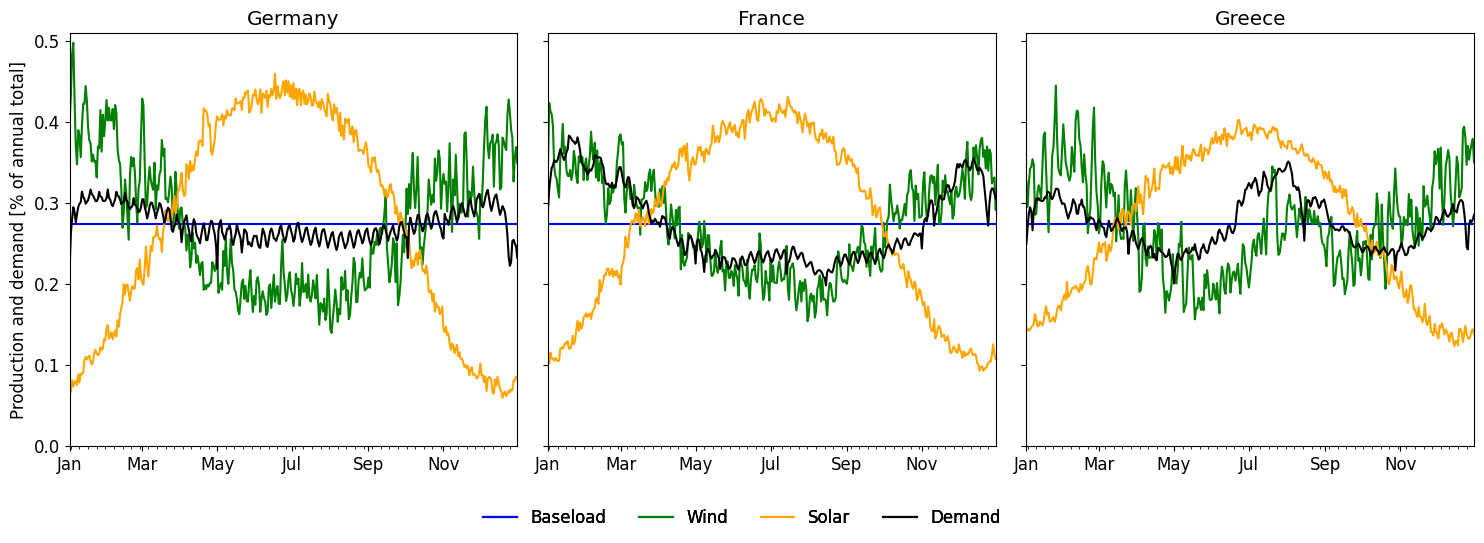

In [9]:
freq = "D"

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))
for i, country in enumerate(COUNTRIES):
    ax = axs[i]
    df_p = (
        df_phi.query(f"country == '{country}'")
        .drop(columns="country")
        .set_index("date")
        .resample(freq)
        .sum()
    )
    for tech in tech_labels.keys():
        df_p[tech].plot(ax=ax, label=tech_labels[tech], color=colors[tech])
        ax.set_ylabel("Production and demand [% of annual total]")
        ax.set_xlabel("")
        ax.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=range(1,13,2)))
        ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
        ax.set_title(country_labels.get(country))
        ax.set_ylim(0, 0.51)
    lines, labels = ax.get_legend_handles_labels()[:3]
    fig.legend(
        lines,
        labels,
        loc="lower center",
        ncol=4,
        bbox_to_anchor=(0.5, -0.1),
        frameon=False,
    )
    plt.tight_layout()
plt.savefig(
    "../figures/demand_renewable_profile.png",
    dpi=300,
    bbox_inches="tight",
)

## Descriptive: Production Profiles

In [10]:
freq ="D"

lst_df = []
lst_df_gap = []
for country in COUNTRIES:
    # select country and resample
    df_ = (
        df_phi
        .query(f"country == '{country}'")
        .drop(columns="country")
        .set_index("date")
        .resample(freq)
        .sum()
        .rename(columns=tech_labels)
    )

    # statistics for the profiles
    df_corr_ = df_.corr()
    df_base_ = (
        df_.describe()
        .loc[["mean", "std", "min", "max"], :]
        .T
        .rename(columns=stat_labels)
    )
    df_stat_profile = (
        pd.concat([df_corr_, df_base_], axis=1)
        .reset_index()
        .rename(columns={"index": "Technology"})
    )
    df_stat_profile.insert(0, "Country", country_labels.get(country))
    lst_df.append(df_stat_profile)

    # statistics for the production gaps
    cols = ["Baseload", "Wind", "Solar"]
    df_gap_ = df_.loc[:, cols].sub(df_["Demand"], axis=0).rename(columns=tech_labels)
    df_gap_base_ = (
        df_gap_.describe().loc[["std", "min", "max"], :].T.rename(columns=stat_labels)
    )
    df_gap_corr_ = df_gap_.corr()
    df_stat_gap = (
        pd.concat([df_gap_base_, df_gap_corr_], axis=1)
        .reset_index()
        .rename(columns={"index": "Technology"})
    )
    df_stat_gap.insert(0, "Country", country_labels.get(country))
    lst_df_gap.append(df_stat_gap)
df_stat_gap = pd.concat(lst_df_gap)
df_stat_profile = pd.concat(lst_df)

In [11]:
wxls = pd.ExcelWriter("../figures/descriptive_profiles.xlsx")
df_stat_profile.set_index(["Country", "Technology"]).to_excel(wxls, sheet_name="Profile")
df_stat_gap.set_index(["Country", "Technology"]).to_excel(
    wxls, sheet_name="Production_Gap"
)
wxls.close()